# Import Library & Setup Environment

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Tahap 1: Exploratory Data Analysis (EDA)

In [2]:
data_dir = "dataset"

classes = os.listdir(data_dir)
data_count = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

for k, v in data_count.items():
    print(f"{k}: {v} gambar ({v/sum(data_count.values())*100:.2f}%)")

Mild Impairment: 2264 gambar (23.18%)
Moderate Impairment: 2217 gambar (22.70%)
No Impairment: 2767 gambar (28.33%)
Very Mild Impairment: 2518 gambar (25.78%)


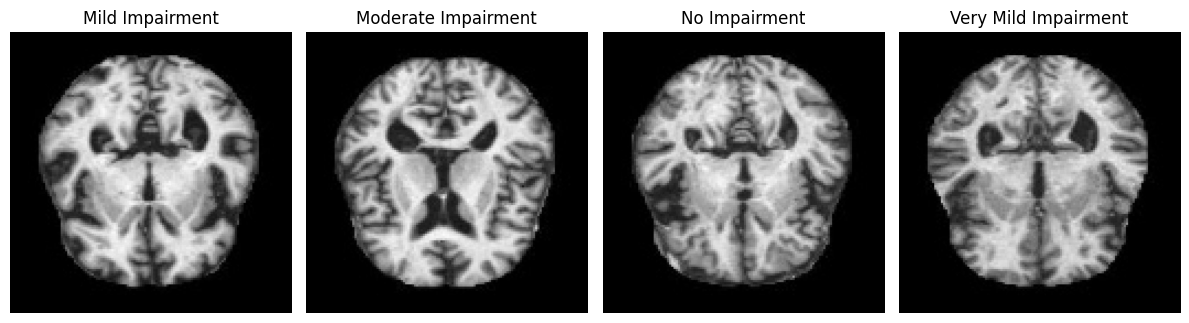

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, cls in zip(axes, classes):
    sample_img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = Image.open(sample_img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
sizes = []
modes = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_path)[:30]:
        img = Image.open(os.path.join(cls_path, img_name))
        sizes.append(img.size)
        modes.append(img.mode)

sizes = np.array(sizes)

print(f"Rata-rata ukuran gambar: {sizes[:,0].mean():.0f} x {sizes[:,1].mean():.0f}")
print(f"Mode warna yang umum: {pd.Series(modes).mode()[0]}")

Rata-rata ukuran gambar: 640 x 640
Mode warna yang umum: RGB


# Tahap 2: Preprocessing Data

In [5]:
data_dir = "dataset"
IMG_SIZE = (224, 224)  # ukuran target gambar

class_names = sorted(os.listdir(data_dir))
print("Kelas yang terdeteksi:", class_names)


Kelas yang terdeteksi: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [6]:
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_folder, filename))
            labels.append(class_name)

df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

In [7]:
# Label encoding numerik
label_to_index = {name: idx for idx, name in enumerate(class_names)}
df['label_idx'] = df['label'].map(label_to_index)

# Split utama: 80% train+val, 20% test
trainval_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label_idx'], random_state=42
)

# Dari 80% train+val, ambil 25% untuk validation → hasil akhirnya 60:20:20
train_df, val_df = train_test_split(
    trainval_df, test_size=0.25, stratify=trainval_df['label_idx'], random_state=42
)

print(f"Train: {len(train_df)} ({len(train_df)/len(df):.2%})")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df):.2%})")
print(f"Test: {len(test_df)} ({len(test_df)/len(df):.2%})")


Train: 5859 (59.99%)
Validation: 1953 (20.00%)
Test: 1954 (20.01%)


In [8]:
def preprocess_image(path):
    # Baca gambar
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # type: ignore
    img = cv2.resize(img, IMG_SIZE)

    # CLAHE untuk meningkatkan kontras (pada channel L di LAB)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    # Normalisasi ke rentang [0, 1]
    img = img / 255.0
    return img


In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 5859 validated image filenames belonging to 4 classes.
Found 1953 validated image filenames belonging to 4 classes.
Found 1954 validated image filenames belonging to 4 classes.


In [11]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)
class_weights = dict(enumerate(class_weights_array))

print("Class Weights:")
for k, v in class_weights.items():
    print(f"  {class_names[k]}: {v:.3f}")


Class Weights:
  Mild Impairment: 1.079
  Moderate Impairment: 1.101
  No Impairment: 0.882
  Very Mild Impairment: 0.969


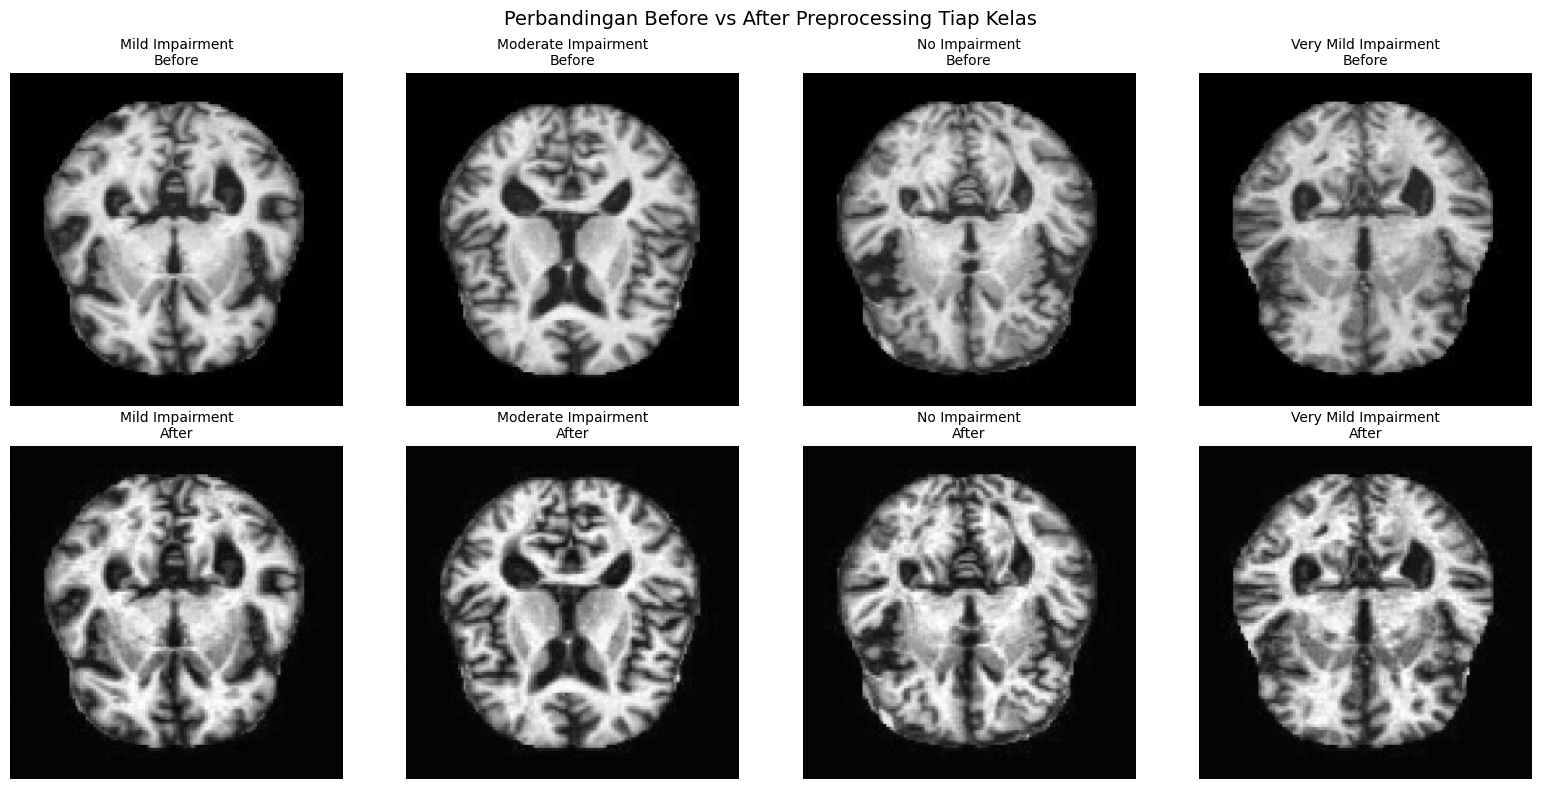

In [12]:
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, cls in enumerate(classes):
    sample_img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    
    img_before = Image.open(sample_img_path)
    axes[0, i].imshow(img_before)
    axes[0, i].set_title(f"{cls}\nBefore", fontsize=10)
    axes[0, i].axis("off")

    img_after = preprocess_image(sample_img_path)
    axes[1, i].imshow(img_after)
    axes[1, i].set_title(f"{cls}\nAfter", fontsize=10)
    axes[1, i].axis("off")

plt.suptitle("Perbandingan Before vs After Preprocessing Tiap Kelas", fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
output_base = "processed_dataset"
splits = ["train", "val", "test"]

for split in splits:
    for cls in class_names:
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)


def save_preprocessed_image(input_path, output_path):
    """Menyimpan gambar hasil preprocessing ke output_path"""
    try:
        img = preprocess_image(input_path)
        img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, img_bgr)
    except Exception as e:
        print(f"Gagal memproses {input_path}: {e}")


def process_subset(subset_df, subset_name):
    """Proses subset (train/val/test) dan simpan hasil preprocessing"""
    print(f"\nMemproses subset: {subset_name} ({len(subset_df)} gambar)")
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
        input_path = row['filename']
        label = row['label']
        fname = os.path.basename(input_path)
        output_path = os.path.join(output_base, subset_name, label, fname)

        if not os.path.exists(output_path):
            save_preprocessed_image(input_path, output_path)

    print(f"Selesai: {subset_name} ({len(subset_df)} gambar)")

process_subset(train_df, "train")
process_subset(val_df, "val")
process_subset(test_df, "test")

print("\nSemua gambar berhasil diproses dan dibagi ke folder train, val, dan test.")


Memproses subset: train (5859 gambar)


100%|██████████| 5859/5859 [00:00<00:00, 19633.53it/s]


Selesai: train (5859 gambar)

Memproses subset: val (1953 gambar)


100%|██████████| 1953/1953 [00:00<00:00, 14046.70it/s]


Selesai: val (1953 gambar)

Memproses subset: test (1954 gambar)


100%|██████████| 1954/1954 [00:00<00:00, 22133.47it/s]

Selesai: test (1954 gambar)

Semua gambar berhasil diproses dan dibagi ke folder train, val, dan test.


In [14]:
def check_corrupted_images(base_dir):
    corrupted_files = []
    total_files = 0
    ok_files = 0

    for root, _, files in os.walk(base_dir):
        for fname in files:
            if fname.lower().endswith(('.jpg')):
                total_files += 1
                fpath = os.path.join(root, fname)
                try:
                    with Image.open(fpath) as img:
                        img.verify()
                    ok_files += 1
                except Exception as e:
                    corrupted_files.append((fpath, str(e)))

    print(f"Total file diperiksa: {total_files}")
    print(f"File valid: {ok_files}")
    print(f"File korup: {len(corrupted_files)}")

    if corrupted_files:
        print("\nDaftar file korup:")
        for f, err in corrupted_files[:10]:
            print(f"  {f} → {err}")

    return corrupted_files

corrupted = check_corrupted_images("processed_dataset")

Total file diperiksa: 9766
File valid: 9766
File korup: 0


# Tahap 3: Feature Extraction

1. Ekstraksi Fitur Tekstur – LBP

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import local_binary_pattern

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Parameter LBP
LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS
RESIZE_SHAPE = (128, 128)  # Samakan ukuran gambar

# === Fungsi Ekstraksi LBP ===
def extract_lbp_features(image_gray):
    """Ekstraksi fitur tekstur menggunakan Local Binary Pattern (LBP)."""
    lbp = local_binary_pattern(image_gray, LBP_POINTS, LBP_RADIUS, method='uniform')
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalisasi histogram
    return hist

# === Proses Ekstraksi dari Folder Dataset ===
def extract_features_from_dataset():
    data = []
    print(f"\n[INFO] Memulai ekstraksi LBP untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    img = cv2.resize(img, RESIZE_SHAPE)
                    lbp_feat = extract_lbp_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(lbp_feat)})
                    data.append(feature_row)
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    return pd.DataFrame(data)

# === Jalankan Proses Ekstraksi ===
df_all = extract_features_from_dataset()

# === Simpan ke file CSV ===
os.makedirs("features_extracted", exist_ok=True)
output_path = os.path.join("features_extracted", "features_lbp_full.csv")
df_all.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi LBP selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi LBP untuk seluruh dataset di 'processed_dataset' ...



Ekstraksi LBP selesai.
   Total data    : 9766
   Jumlah fitur  : 19
   File disimpan : features_extracted\features_lbp_full.csv


2. Ekstraksi Fitur Bentuk – HOG

In [68]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Pastikan folder output ada
os.makedirs(output_dir, exist_ok=True)

# === Parameter HOG ===
HOG_PARAMS = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys",
    "transform_sqrt": True
}

RESIZE_SHAPE = (128, 128)

def extract_hog_features(image_gray):
    """Ekstraksi fitur bentuk/tepi menggunakan Histogram of Oriented Gradients (HOG)."""
    image_gray = cv2.resize(image_gray, RESIZE_SHAPE)
    features = hog(image_gray, **HOG_PARAMS)
    return features

# === Ekstraksi fitur dari seluruh dataset ===
def extract_hog_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi HOG untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    feat = extract_hog_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# === Jalankan Ekstraksi ===
df_all = extract_hog_from_dataset()

# === Simpan hasil ===
output_path = os.path.join(output_dir, "features_hog_full.csv")
df_all.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi HOG selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi HOG untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi HOG selesai.
   Total data    : 9766
   Jumlah fitur  : 8101
   File disimpan : features_extracted\features_hog_full.csv


3. Zernike Moments

In [69]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from mahotas.features import zernike_moments

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Pastikan folder output tersedia
os.makedirs(output_dir, exist_ok=True)

# === Parameter Zernike ===
ZERN_RADIUS = 64
ZERN_DEGREE = 8
RESIZE_SHAPE = (ZERN_RADIUS * 2, ZERN_RADIUS * 2)

def extract_zernike_features(image_gray, radius=ZERN_RADIUS, degree=ZERN_DEGREE):
    """
    Ekstraksi fitur bentuk global menggunakan Zernike Moments.
    """
    # Resize gambar agar simetris dan sesuai radius
    image_gray = cv2.resize(image_gray, RESIZE_SHAPE)
    # Normalisasi dan konversi ke biner (threshold adaptif agar tidak salah segmentasi)
    _, binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = binary.astype(np.uint8)
    # Hitung Zernike Moments
    return zernike_moments(binary, radius, degree=degree)

# === Proses Ekstraksi dari Folder Dataset ===
def extract_zernike_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi Zernike Moments untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    feat = extract_zernike_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# === Jalankan Ekstraksi ===
df_all = extract_zernike_from_dataset()

# === Simpan hasil ===
output_path = os.path.join(output_dir, "features_zernike_full.csv")
df_all.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi Zernike Moments selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Zernike Moments untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Zernike Moments selesai.
   Total data    : 9766
   Jumlah fitur  : 26
   File disimpan : features_extracted\features_zernike_full.csv


4. Wavelet Features

In [70]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import pywt
from scipy.stats import skew, kurtosis

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Pastikan folder output tersedia
os.makedirs(output_dir, exist_ok=True)

# === Parameter Wavelet ===
WAVELET_FAMILIES = ('haar', 'db4', 'sym5', 'coif1')
WAVELET_LEVEL = 3
RESIZE_SHAPE = (128, 128)

def extract_wavelet_features(image_gray, families=WAVELET_FAMILIES, level=WAVELET_LEVEL):
    """
    Ekstraksi fitur Wavelet multi-level & multi-family dengan statistik dasar (mean, std, skewness, kurtosis)
    """
    features = []
    for wavelet in families:
        coeffs = pywt.wavedec2(image_gray, wavelet=wavelet, level=level)
        for i, coeff in enumerate(coeffs):
            if i == 0:
                cA = coeff
                stats = [np.mean(cA), np.std(cA), skew(cA.flatten()), kurtosis(cA.flatten())]
                features.extend(stats)
            else:
                cH, cV, cD = coeff
                for c in [cH, cV, cD]:
                    stats = [np.mean(c), np.std(c), skew(c.flatten()), kurtosis(c.flatten())]
                    features.extend(stats)
    return np.array(features, dtype=float)

# === Ekstraksi Fitur Wavelet dari Seluruh Dataset ===
def extract_wavelet_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi Wavelet untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    img = cv2.resize(img, RESIZE_SHAPE)
                    img = cv2.equalizeHist(img)

                    feat = extract_wavelet_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# === Jalankan Ekstraksi ===
df_all = extract_wavelet_from_dataset()

# === Bersihkan NaN (jika ada) ===
feature_cols = [c for c in df_all.columns if c.startswith('f')]
df_all[feature_cols] = df_all[feature_cols].apply(pd.to_numeric, errors='coerce')
nan_count = df_all[feature_cols].isna().sum().sum()
if nan_count > 0:
    print(f"[WARN] Ditemukan {nan_count} nilai NaN, akan diganti dengan 0.")
    df_all[feature_cols] = df_all[feature_cols].fillna(0)

# === Simpan ke File CSV ===
output_path = os.path.join(output_dir, "features_wavelet_full.csv")
df_all.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len(feature_cols)
print("\nEkstraksi Wavelet selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Wavelet untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766
[WARN] Ditemukan 9766 nilai NaN, akan diganti dengan 0.

Ekstraksi Wavelet selesai.
   Total data    : 9766
   Jumlah fitur  : 161
   File disimpan : features_extracted\features_wavelet_full.csv


5. GLCM (Gray Level Co-occurrence Matrix)

In [43]:
import os
import cv2
import numpy as np
import pandas as pd
import mahotas
from tqdm import tqdm

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
RESIZE_SHAPE = (128, 128)
NUM_BLOCKS = 4  # 4x4 blok citra

os.makedirs(output_dir, exist_ok=True)

# === Fungsi Ekstraksi Haralick multi-block ===
def extract_haralick_multiblock(img_gray, num_blocks=NUM_BLOCKS):
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    block_size = RESIZE_SHAPE[0] // num_blocks
    features = []

    for i in range(num_blocks):
        for j in range(num_blocks):
            patch = img_eq[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            haralick = mahotas.features.haralick(patch).mean(axis=0)
            features.extend(haralick)

    return np.array(features, dtype=float)

# === Ekstraksi dataset ===
def extract_haralick_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi Haralick multi-block untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    features = extract_haralick_multiblock(img)
                    feature_row = {'file_path': fpath, 'label': label, 'split': split}
                    feature_row.update({f'f{i}': v for i, v in enumerate(features)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# === Jalankan ekstraksi ===
df_haralick = extract_haralick_dataset()
output_path = os.path.join(output_dir, "features_glcm_multiblock.csv")
df_haralick.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_haralick.columns if c.startswith('f')])
print("\nEkstraksi Haralick multi-block selesai.")
print(f"   Total data    : {len(df_haralick)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Haralick multi-block untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Haralick multi-block selesai.
   Total data    : 9766
   Jumlah fitur  : 209
   File disimpan : features_extracted\features_glcm_multiblock.csv


6. FFT

In [24]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.fft import fft2

# Konfigurasi
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train","val","test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
RESIZE_SHAPE = (128,128)
TOP_N = 256  # jumlah fitur FFT yang disimpan

# Pastikan folder output ada
os.makedirs(output_dir, exist_ok=True)

def extract_fft_features(img_gray):
    fft_img = fft2(img_gray)
    fft_mag = np.abs(fft_img).flatten()
    if len(fft_mag) > TOP_N:
        fft_mag = fft_mag[:TOP_N]
    else:
        fft_mag = np.pad(fft_mag, (0, TOP_N - len(fft_mag)))
    return fft_mag

def extract_fft_dataset():
    data = []
    total = 0

    print(f"[INFO] Memulai ekstraksi FFT untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, RESIZE_SHAPE)
                img = cv2.equalizeHist(img)

                feats = extract_fft_features(img)
                row = {'file_path': fpath, 'label': label, 'split': split}
                row.update({f'f{i}': v for i,v in enumerate(feats)})
                data.append(row)
                total += 1

    print(f"[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# Ekstraksi FFT seluruh dataset
df_fft = extract_fft_dataset()

# Simpan ke CSV
output_path = os.path.join(output_dir,"features_fft_full.csv")
df_fft.to_csv(output_path, index=False)
print(f"[INFO] FFT extraction done. File saved to: {output_path}")


[INFO] Memulai ekstraksi FFT untuk seluruh dataset di 'processed_dataset' ...


[INFO] Total gambar berhasil diproses: 9766
[INFO] FFT extraction done. File saved to: features_extracted\features_fft_full.csv


7. GIST Descriptors

In [41]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Konfigurasi dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
RESIZE_SHAPE = (128, 128)
NUM_BLOCKS = 4  # 4x4 blok citra

# Gabor parameters
GABOR_THETAS = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
GABOR_SCALES = [4, 8, 16]  # ukuran kernel
GABOR_LAMBDA = 10.0
GABOR_GAMMA = 0.5
GABOR_PSI = 0

os.makedirs(output_dir, exist_ok=True)

# === Fungsi ekstraksi GIST-like multi-block ===
def extract_gist_like_multiblock(img_gray, num_blocks=NUM_BLOCKS):
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    block_size = RESIZE_SHAPE[0] // num_blocks
    features = []

    for i in range(num_blocks):
        for j in range(num_blocks):
            patch = img_eq[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            for theta in GABOR_THETAS:
                for ksize in GABOR_SCALES:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma=4.0, theta=theta,
                                                lambd=GABOR_LAMBDA, gamma=GABOR_GAMMA, psi=GABOR_PSI)
                    filtered = cv2.filter2D(patch, cv2.CV_32F, kernel)
                    features.extend([filtered.mean(), filtered.std()])

    return np.array(features, dtype=float)

# === Ekstraksi dataset ===
def extract_gist_like_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi GIST-like multi-block untuk seluruh dataset ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                continue
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    feats = extract_gist_like_multiblock(img)
                    row = {'file_path': fpath, 'label': label, 'split': split}
                    row.update({f'f{i}': v for i, v in enumerate(feats)})
                    data.append(row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# === Jalankan ekstraksi ===
df_gist_like = extract_gist_like_dataset()
output_path = os.path.join(output_dir, "features_gist_like_multiblock.csv")
df_gist_like.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_gist_like.columns if c.startswith('f')])
print("\nEkstraksi GIST-like multi-block selesai.")
print(f"   Total data    : {len(df_gist_like)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi GIST-like multi-block untuk seluruh dataset ...


train/Mild Impairment:   0%|          | 0/1358 [00:00<?, ?it/s]


[INFO] Total gambar berhasil diproses: 9766

Ekstraksi GIST-like multi-block selesai.
   Total data    : 9766
   Jumlah fitur  : 769
   File disimpan : features_extracted\features_gist_like_multiblock.csv


8. Hu moment

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Konfigurasi Dataset ===
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
RESIZE_SHAPE = (128, 128)
NUM_PATCHES = 4  # Bagi citra menjadi 4x4 patch

os.makedirs(output_dir, exist_ok=True)

# === Fungsi ekstraksi Hu Moments multi-patch ===
def extract_hu_moments_multiscale(img_gray, num_patches=NUM_PATCHES):
    """
    Ekstraksi Hu Moments untuk setiap patch citra.
    img_gray : citra grayscale
    num_patches : jumlah patch per sisi (num_patches x num_patches)
    """
    # Resize dan CLAHE
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    patch_size = RESIZE_SHAPE[0] // num_patches
    features = []

    for i in range(num_patches):
        for j in range(num_patches):
            patch = img_eq[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            moments = cv2.moments(patch)
            hu = cv2.HuMoments(moments).flatten()
            # Log transform untuk stabilitas skala
            hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
            features.extend(hu_log)

    return np.array(features, dtype=float)

# === Ekstraksi dataset ===
def extract_hu_moments_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi Hu Moments multi-patch untuk seluruh dataset ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                continue
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    feats = extract_hu_moments_multiscale(img)
                    row = {'file_path': fpath, 'label': label, 'split': split}
                    row.update({f'f{i}': v for i, v in enumerate(feats)})
                    data.append(row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# === Jalankan ekstraksi ===
df_hu = extract_hu_moments_dataset()
output_path = os.path.join(output_dir, "features_hu_moments_multi_patch.csv")
df_hu.to_csv(output_path, index=False)

# === Ringkasan ===
num_features = len([c for c in df_hu.columns if c.startswith('f')])
print("\nEkstraksi Hu Moments multi-patch selesai.")
print(f"   Total data    : {len(df_hu)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Hu Moments multi-patch untuk seluruh dataset ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Hu Moments multi-patch selesai.
   Total data    : 9766
   Jumlah fitur  : 113
   File disimpan : features_extracted\features_hu_moments_multi_patch.csv


# Tahap 5: Model Training

In [ ]:
# build_models.py
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import joblib

# Folder fitur
features_dir = "features_extracted"
output_dir = "trained_models"
os.makedirs(output_dir, exist_ok=True)

# File CSV fitur
files = {
    "hog": "features_hog_full.csv",
    "zernike": "features_zernike_full.csv",
    "wavelet": "features_wavelet_full.csv",
    "glcm": "features_glcm_full.csv",
    "lbp": "features_lbp_full.csv",
    "fft": "features_fft_full.csv",
    "gist": "features_gist_like_multiblock.csv",
    "hu": "features_hu_moments_multi_patch.csv"
}

for name, fname in files.items():
    fpath = os.path.join(features_dir, fname)
    if not os.path.exists(fpath):
        print(f"[WARN] File tidak ditemukan: {fpath}")
        continue

    df = pd.read_csv(fpath)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print(f"[SKIP] File {fname} tidak memiliki kolom numerik")
        continue

    X = df[numeric_cols].fillna(0)
    y = df['label']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # ====================
    # XGBoost
    # ====================
    xgb_model = XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)

    # ====================
    # MLP
    # ====================
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    mlp_model.fit(X_train, y_train)

    # Simpan model, scaler, dan label encoder
    save_path = os.path.join(output_dir, f"{name}_models.pkl")
    joblib.dump({
        "xgb": xgb_model,
        "mlp": mlp_model,
        "label_encoder": le,
        "scaler": scaler,
        "X_test": X_test,
        "y_test": y_test
    }, save_path)

    print(f"[INFO] Model {name} berhasil disimpan -> {save_path}")


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model hog berhasil disimpan -> trained_models\hog_models.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:25:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model zernike berhasil disimpan -> trained_models\zernike_models.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:26:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model wavelet berhasil disimpan -> trained_models\wavelet_models.pkl
[WARN] File tidak ditemukan: features_extracted\features_glcm_full.csv


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:27:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model lbp berhasil disimpan -> trained_models\lbp_models.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:29:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model fft berhasil disimpan -> trained_models\fft_models.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:30:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model gist berhasil disimpan -> trained_models\gist_models.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:33:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Model hu berhasil disimpan -> trained_models\hu_models.pkl


In [66]:
# build_models_evaluation_ready_xgb_only.py
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib

# Folder fitur
features_dir = "features_extracted"
output_dir = "trained_models"
os.makedirs(output_dir, exist_ok=True)

# File CSV fitur
files = {
    "hog": "features_hog.csv",
    "zernike": "features_zernike.csv",
    "wavelet": "features_wavelet.csv",
    "glcm": "features_glcm_multiblock.csv",
    "lbp": "features_lbp.csv",
    "fft": "features_fft.csv",
    "gist": "features_gist_like_multiblock.csv",
    "hu": "features_hu_moments_multi_patch.csv"
}

for name, fname in files.items():
    fpath = os.path.join(features_dir, fname)
    if not os.path.exists(fpath):
        print(f"[WARN] File tidak ditemukan: {fpath}")
        continue

    df = pd.read_csv(fpath)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print(f"[SKIP] File {fname} tidak memiliki kolom numerik")
        continue

    X = df[numeric_cols].fillna(0)
    y = df['label']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ====================
    # Split train / val / test
    # ====================
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
    )
    # 60% train, 20% val, 20% test

    # ====================
    # XGBoost dengan eval_set untuk loss & akurasi
    # ====================
    xgb_model = XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    # Ambil evals_result untuk plot loss & aprox accuracy
    evals_result = xgb_model.evals_result()
    xgb_train_loss = evals_result['validation_0']['mlogloss']
    xgb_val_loss = evals_result['validation_1']['mlogloss']
    # Aproksimasi akurasi dari logloss
    xgb_train_acc = [1 - l/max(xgb_train_loss) for l in xgb_train_loss]
    xgb_val_acc = [1 - l/max(xgb_val_loss) for l in xgb_val_loss]

    # Simpan model, scaler, label encoder, dan data siap plot
    save_path = os.path.join(output_dir, f"{name}_xgb_model.pkl")
    joblib.dump({
        "xgb": xgb_model,
        "label_encoder": le,
        "scaler": scaler,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
        "xgb_train_loss": xgb_train_loss,
        "xgb_val_loss": xgb_val_loss,
        "xgb_train_acc": xgb_train_acc,
        "xgb_val_acc": xgb_val_acc
    }, save_path)

    print(f"[INFO] XGBoost Model {name} berhasil disimpan -> {save_path}")


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:28:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model hog berhasil disimpan -> trained_models\hog_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model zernike berhasil disimpan -> trained_models\zernike_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model wavelet berhasil disimpan -> trained_models\wavelet_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model glcm berhasil disimpan -> trained_models\glcm_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model lbp berhasil disimpan -> trained_models\lbp_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model fft berhasil disimpan -> trained_models\fft_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model gist berhasil disimpan -> trained_models\gist_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:42:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model hu berhasil disimpan -> trained_models\hu_xgb_model.pkl


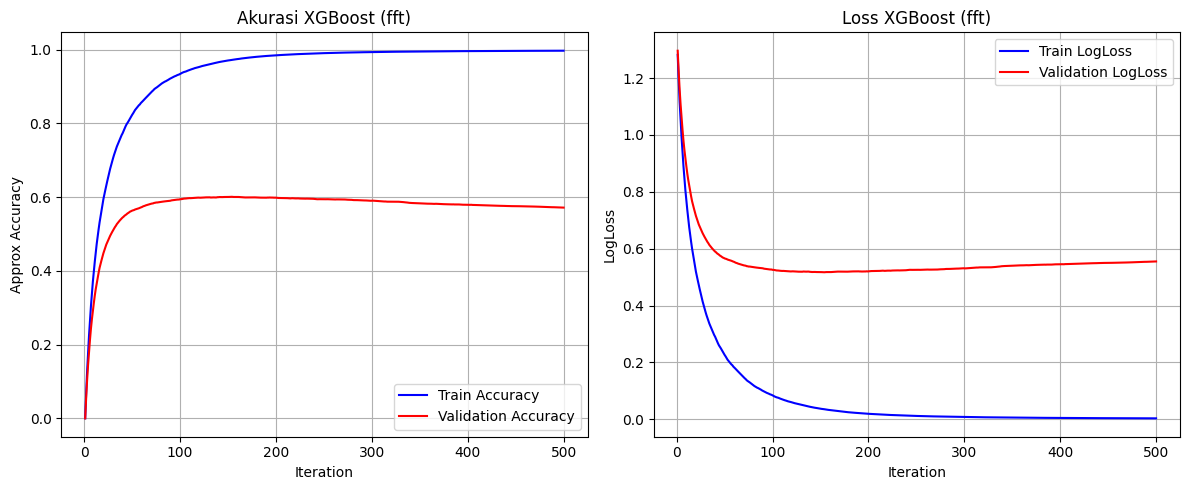

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\fft_xgb_accuracy_loss.png


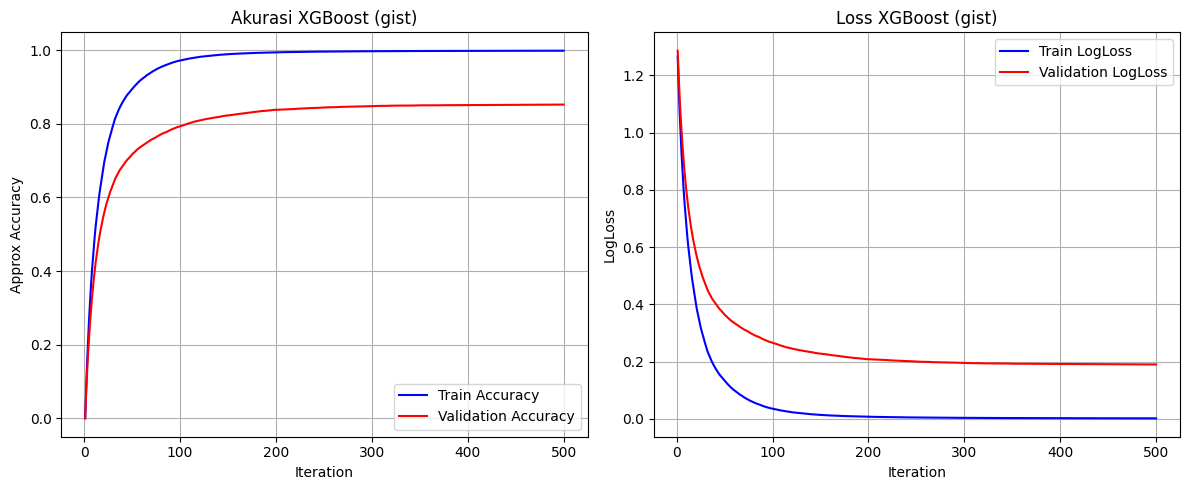

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\gist_xgb_accuracy_loss.png


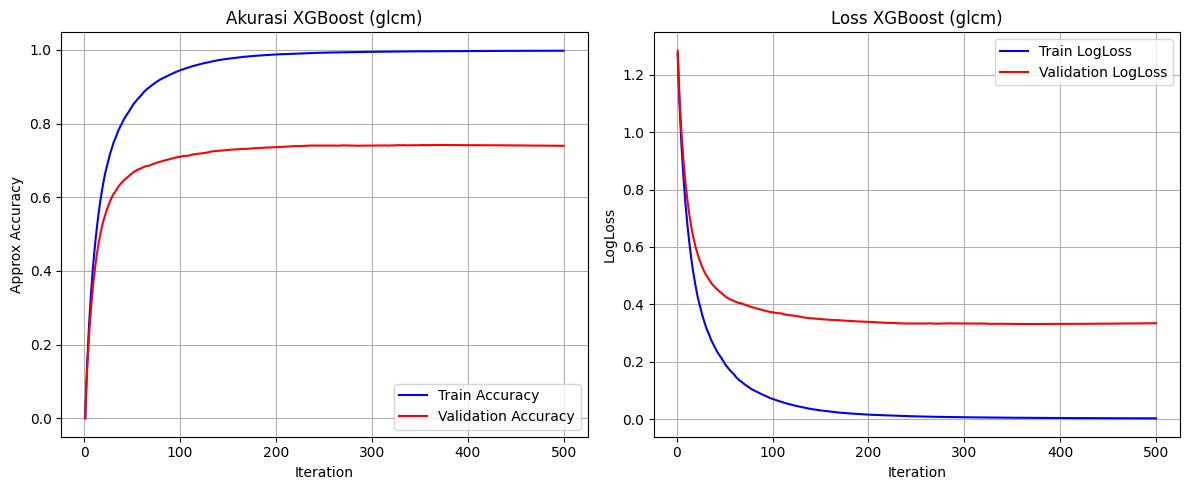

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\glcm_xgb_accuracy_loss.png


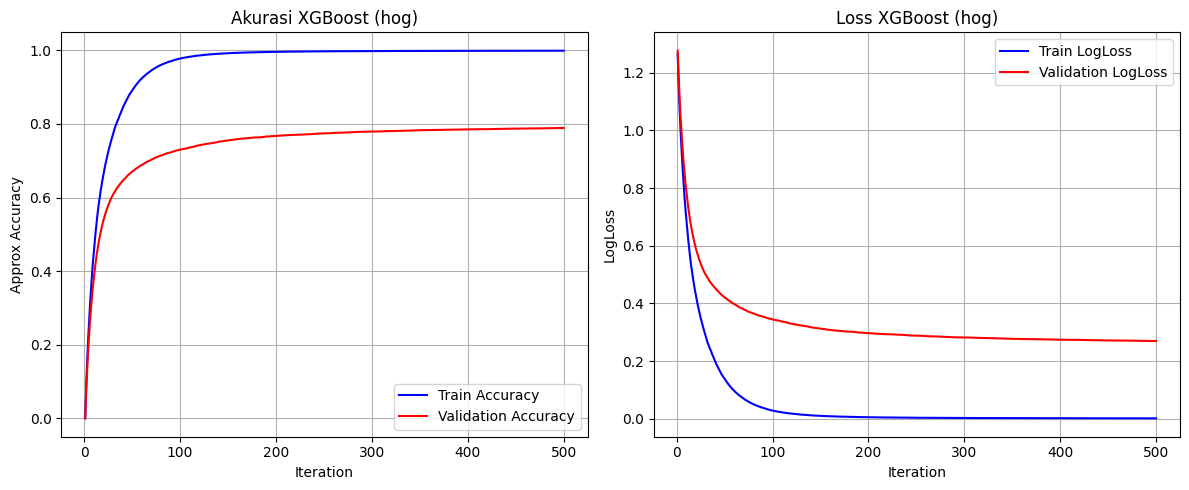

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\hog_xgb_accuracy_loss.png


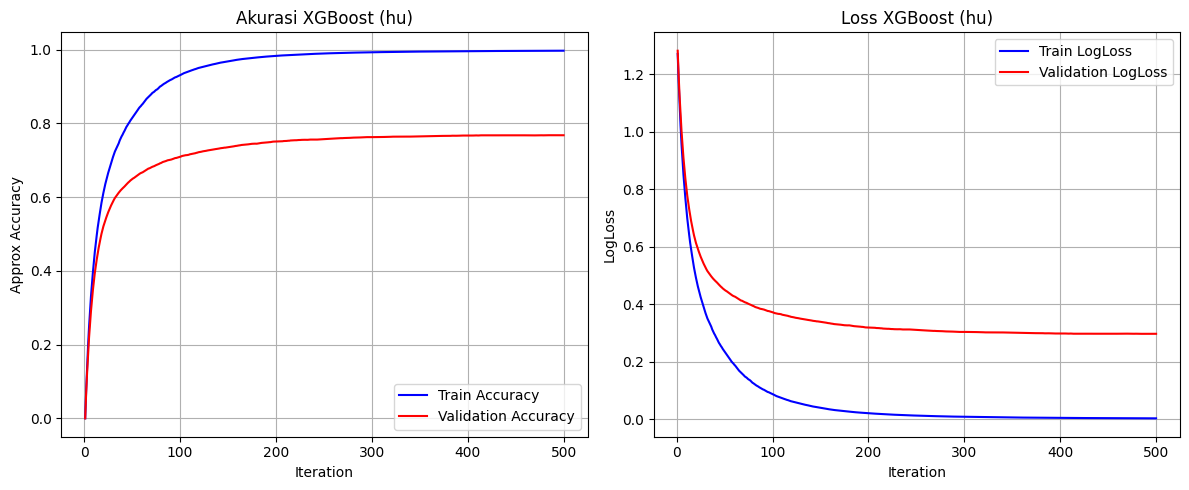

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\hu_xgb_accuracy_loss.png


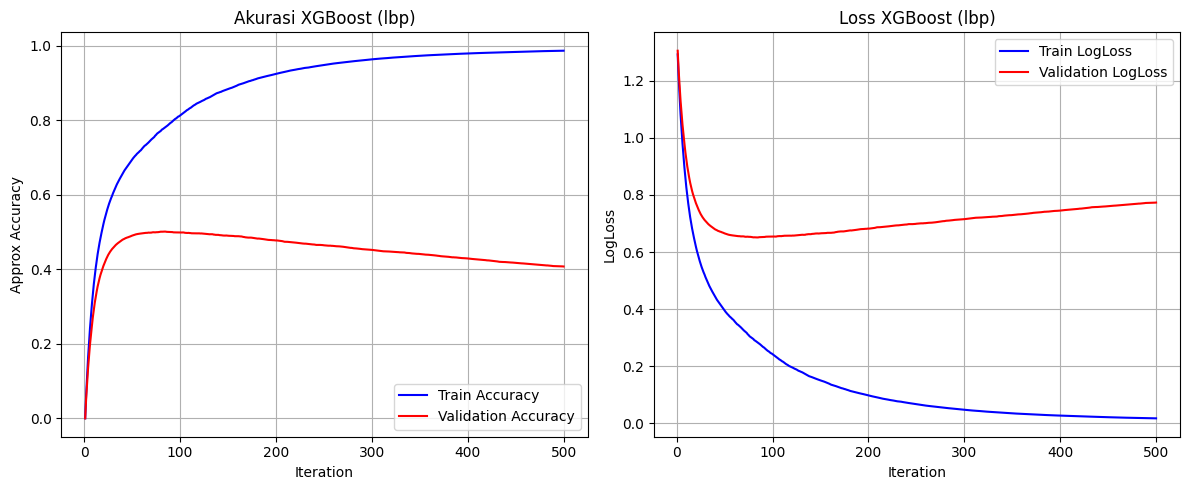

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\lbp_xgb_accuracy_loss.png


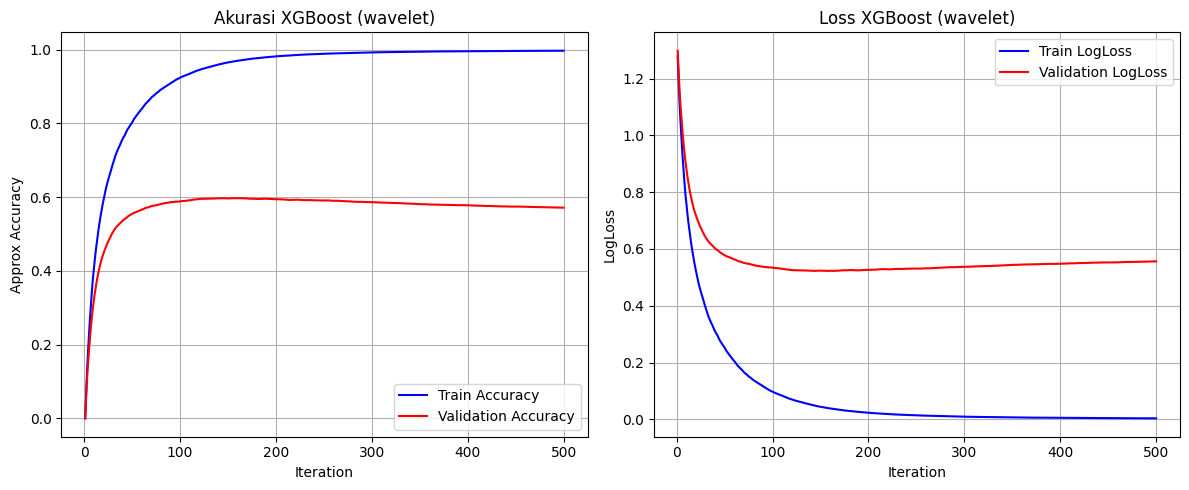

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\wavelet_xgb_accuracy_loss.png


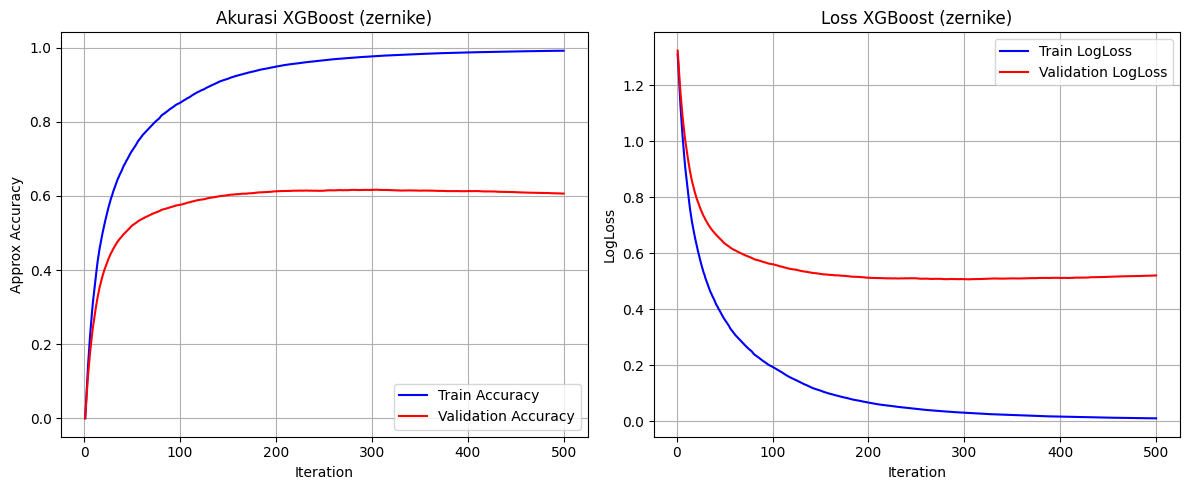

[INFO] Plot Accuracy & Loss XGBoost disimpan: plots\zernike_xgb_accuracy_loss.png


In [69]:
# visualize_accuracy_loss_xgb_only.py
import os
import joblib
import matplotlib.pyplot as plt

model_dir = "trained_models"
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb = data["xgb"]

    # Ambil data evaluasi dari hasil training
    xgb_train_acc = data.get("xgb_train_acc", None)
    xgb_val_acc = data.get("xgb_val_acc", None)
    xgb_train_loss = data.get("xgb_train_loss", None)
    xgb_val_loss = data.get("xgb_val_loss", None)

    plt.figure(figsize=(12,5))

    # ====================
    # Subplot kiri: Akurasi XGBoost
    # ====================
    plt.subplot(1,2,1)
    if xgb_train_acc and xgb_val_acc:
        plt.plot(range(1, len(xgb_train_acc)+1), xgb_train_acc, label='Train Accuracy', color='blue')
        plt.plot(range(1, len(xgb_val_acc)+1), xgb_val_acc, label='Validation Accuracy', color='red')
    plt.title(f"Akurasi XGBoost ({feature_name})")
    plt.xlabel("Iteration")
    plt.ylabel("Approx Accuracy")
    plt.grid(True)
    plt.legend()

    # ====================
    # Subplot kanan: Loss XGBoost
    # ====================
    plt.subplot(1,2,2)
    if xgb_train_loss and xgb_val_loss:
        plt.plot(range(1, len(xgb_train_loss)+1), xgb_train_loss, label='Train LogLoss', color='blue')
        plt.plot(range(1, len(xgb_val_loss)+1), xgb_val_loss, label='Validation LogLoss', color='red')
    plt.title(f"Loss XGBoost ({feature_name})")
    plt.xlabel("Iteration")
    plt.ylabel("LogLoss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    save_path = os.path.join(plot_dir, f"{feature_name}_xgb_accuracy_loss.png")
    plt.savefig(save_path)
    plt.show()
    print(f"[INFO] Plot Accuracy & Loss XGBoost disimpan: {save_path}")


# Tahap 6: Evaluation

In [73]:
# evaluate_models_validation.py
import os
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model_dir = "trained_models"

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    le = data["label_encoder"]

    # Pastikan ada X_val & y_val, jika tidak fallback ke X_test & y_test
    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])

    # ====================
    # Evaluasi XGBoost pada Validation Set
    # ====================
    y_pred_xgb = data["xgb"].predict(X_val)
    acc_xgb = accuracy_score(y_val, y_pred_xgb)

    print(f"\n=== Evaluasi Fitur: {feature_name} | Model: XGBoost (Validation) ===")
    print(f"Akurasi: {acc_xgb*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_val, y_pred_xgb, target_names=le.classes_))
    print("Confusion Matrix:")
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_xgb),
                       index=le.classes_, columns=le.classes_))



=== Evaluasi Fitur: fft | Model: XGBoost (Validation) ===
Akurasi: 78.19%
Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.89      0.75      0.81       453
 Moderate Impairment       1.00      0.99      0.99       444
       No Impairment       0.65      0.83      0.73       553
Very Mild Impairment       0.68      0.58      0.63       503

            accuracy                           0.78      1953
           macro avg       0.81      0.79      0.79      1953
        weighted avg       0.79      0.78      0.78      1953

Confusion Matrix:
                      Mild Impairment  Moderate Impairment  No Impairment  \
Mild Impairment                   338                    2             63   
Moderate Impairment                 0                  438              2   
No Impairment                      10                    0            460   
Very Mild Impairment               30                    0            182   


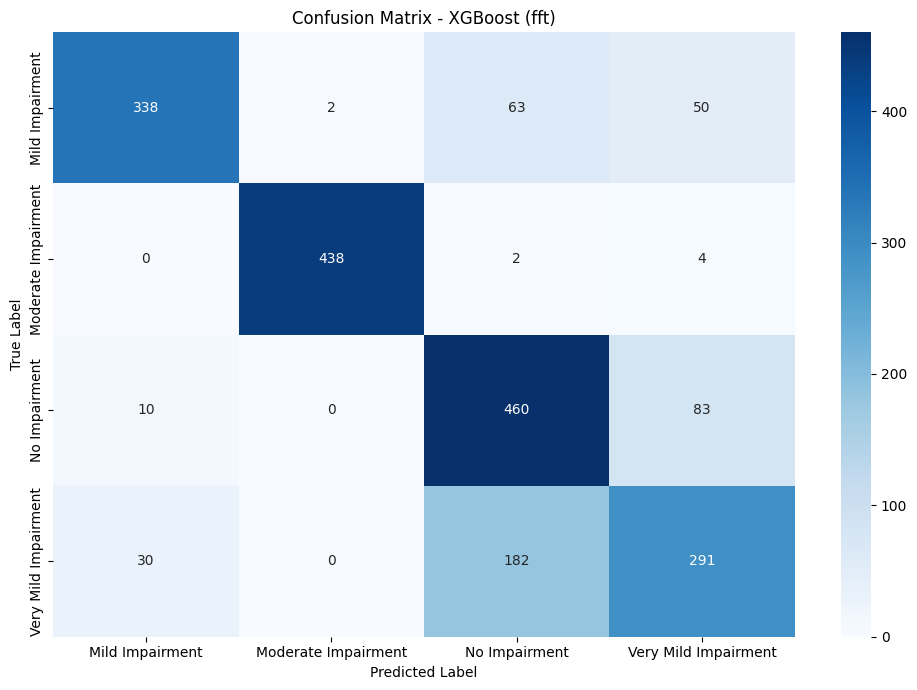

[INFO] Confusion matrix disimpan -> error_analysis\fft_confusion_matrix.png

=== Top Misclassified Classes - fft ===
True: Very Mild Impairment → Pred: No Impairment | Count: 182
True: No Impairment → Pred: Very Mild Impairment | Count: 83
True: Mild Impairment → Pred: No Impairment | Count: 63
True: Mild Impairment → Pred: Very Mild Impairment | Count: 50
True: Very Mild Impairment → Pred: Mild Impairment | Count: 30
True: No Impairment → Pred: Mild Impairment | Count: 10
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 4
True: Mild Impairment → Pred: Moderate Impairment | Count: 2
True: Moderate Impairment → Pred: No Impairment | Count: 2


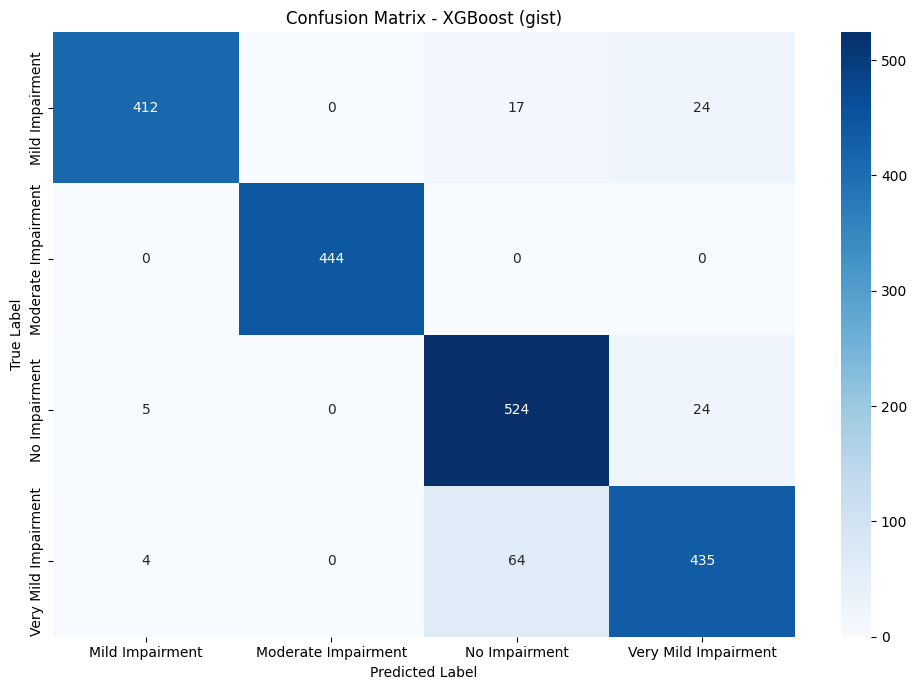

[INFO] Confusion matrix disimpan -> error_analysis\gist_confusion_matrix.png

=== Top Misclassified Classes - gist ===
True: Very Mild Impairment → Pred: No Impairment | Count: 64
True: Mild Impairment → Pred: Very Mild Impairment | Count: 24
True: No Impairment → Pred: Very Mild Impairment | Count: 24
True: Mild Impairment → Pred: No Impairment | Count: 17
True: No Impairment → Pred: Mild Impairment | Count: 5
True: Very Mild Impairment → Pred: Mild Impairment | Count: 4


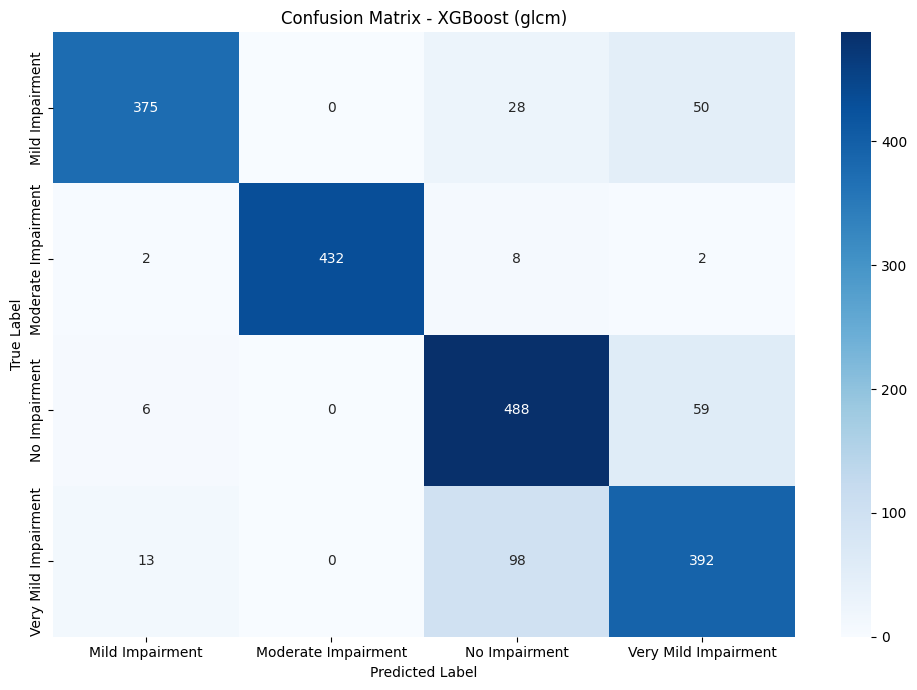

[INFO] Confusion matrix disimpan -> error_analysis\glcm_confusion_matrix.png

=== Top Misclassified Classes - glcm ===
True: Very Mild Impairment → Pred: No Impairment | Count: 98
True: No Impairment → Pred: Very Mild Impairment | Count: 59
True: Mild Impairment → Pred: Very Mild Impairment | Count: 50
True: Mild Impairment → Pred: No Impairment | Count: 28
True: Very Mild Impairment → Pred: Mild Impairment | Count: 13
True: Moderate Impairment → Pred: No Impairment | Count: 8
True: No Impairment → Pred: Mild Impairment | Count: 6
True: Moderate Impairment → Pred: Mild Impairment | Count: 2
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 2


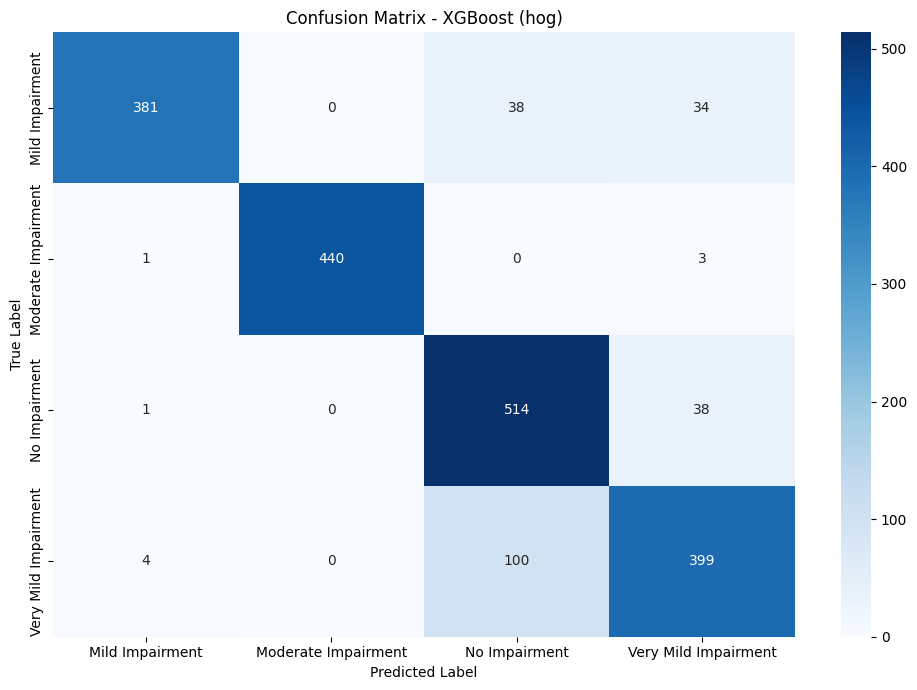

[INFO] Confusion matrix disimpan -> error_analysis\hog_confusion_matrix.png

=== Top Misclassified Classes - hog ===
True: Very Mild Impairment → Pred: No Impairment | Count: 100
True: Mild Impairment → Pred: No Impairment | Count: 38
True: No Impairment → Pred: Very Mild Impairment | Count: 38
True: Mild Impairment → Pred: Very Mild Impairment | Count: 34
True: Very Mild Impairment → Pred: Mild Impairment | Count: 4
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 3
True: Moderate Impairment → Pred: Mild Impairment | Count: 1
True: No Impairment → Pred: Mild Impairment | Count: 1


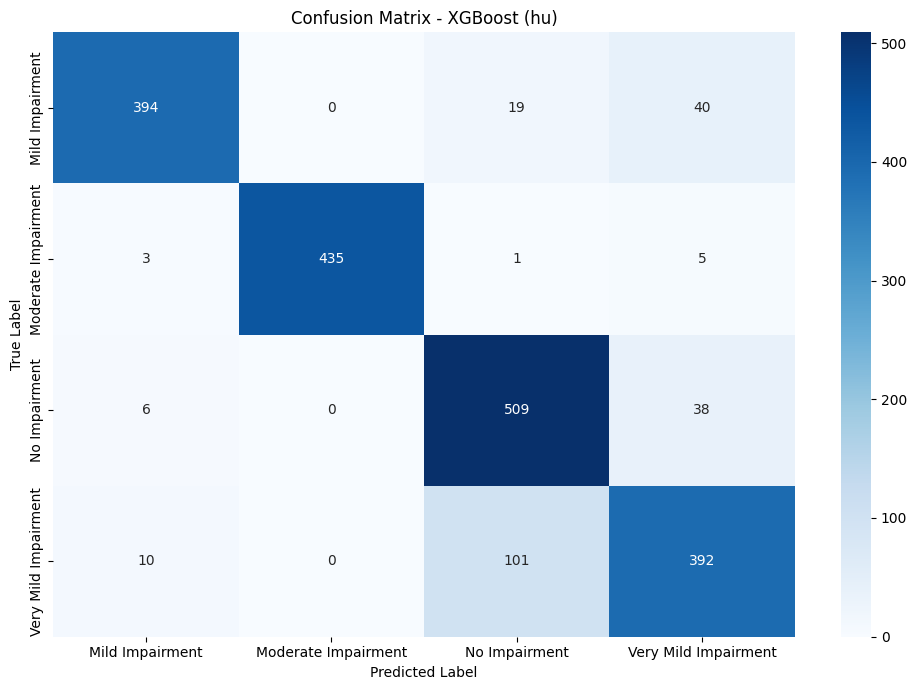

[INFO] Confusion matrix disimpan -> error_analysis\hu_confusion_matrix.png

=== Top Misclassified Classes - hu ===
True: Very Mild Impairment → Pred: No Impairment | Count: 101
True: Mild Impairment → Pred: Very Mild Impairment | Count: 40
True: No Impairment → Pred: Very Mild Impairment | Count: 38
True: Mild Impairment → Pred: No Impairment | Count: 19
True: Very Mild Impairment → Pred: Mild Impairment | Count: 10
True: No Impairment → Pred: Mild Impairment | Count: 6
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 5
True: Moderate Impairment → Pred: Mild Impairment | Count: 3
True: Moderate Impairment → Pred: No Impairment | Count: 1


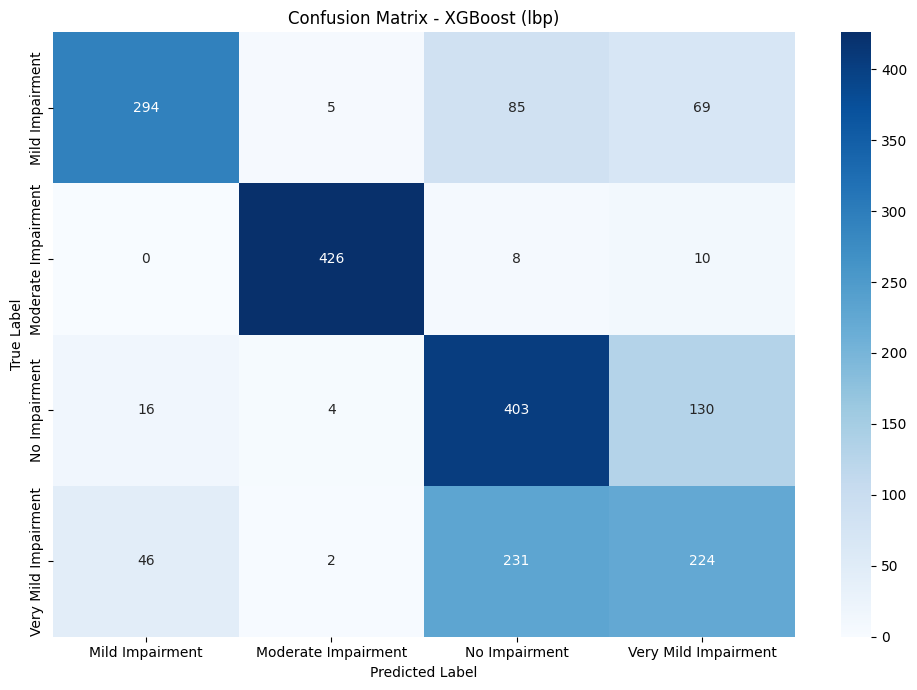

[INFO] Confusion matrix disimpan -> error_analysis\lbp_confusion_matrix.png

=== Top Misclassified Classes - lbp ===
True: Very Mild Impairment → Pred: No Impairment | Count: 231
True: No Impairment → Pred: Very Mild Impairment | Count: 130
True: Mild Impairment → Pred: No Impairment | Count: 85
True: Mild Impairment → Pred: Very Mild Impairment | Count: 69
True: Very Mild Impairment → Pred: Mild Impairment | Count: 46
True: No Impairment → Pred: Mild Impairment | Count: 16
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 10
True: Moderate Impairment → Pred: No Impairment | Count: 8
True: Mild Impairment → Pred: Moderate Impairment | Count: 5
True: No Impairment → Pred: Moderate Impairment | Count: 4


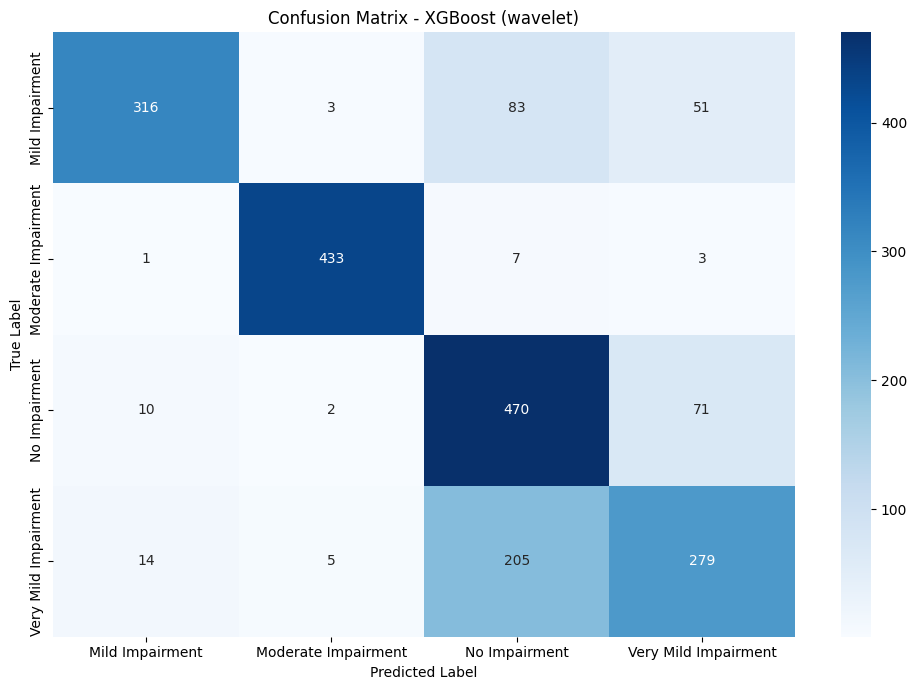

[INFO] Confusion matrix disimpan -> error_analysis\wavelet_confusion_matrix.png

=== Top Misclassified Classes - wavelet ===
True: Very Mild Impairment → Pred: No Impairment | Count: 205
True: Mild Impairment → Pred: No Impairment | Count: 83
True: No Impairment → Pred: Very Mild Impairment | Count: 71
True: Mild Impairment → Pred: Very Mild Impairment | Count: 51
True: Very Mild Impairment → Pred: Mild Impairment | Count: 14
True: No Impairment → Pred: Mild Impairment | Count: 10
True: Moderate Impairment → Pred: No Impairment | Count: 7
True: Very Mild Impairment → Pred: Moderate Impairment | Count: 5
True: Mild Impairment → Pred: Moderate Impairment | Count: 3
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 3


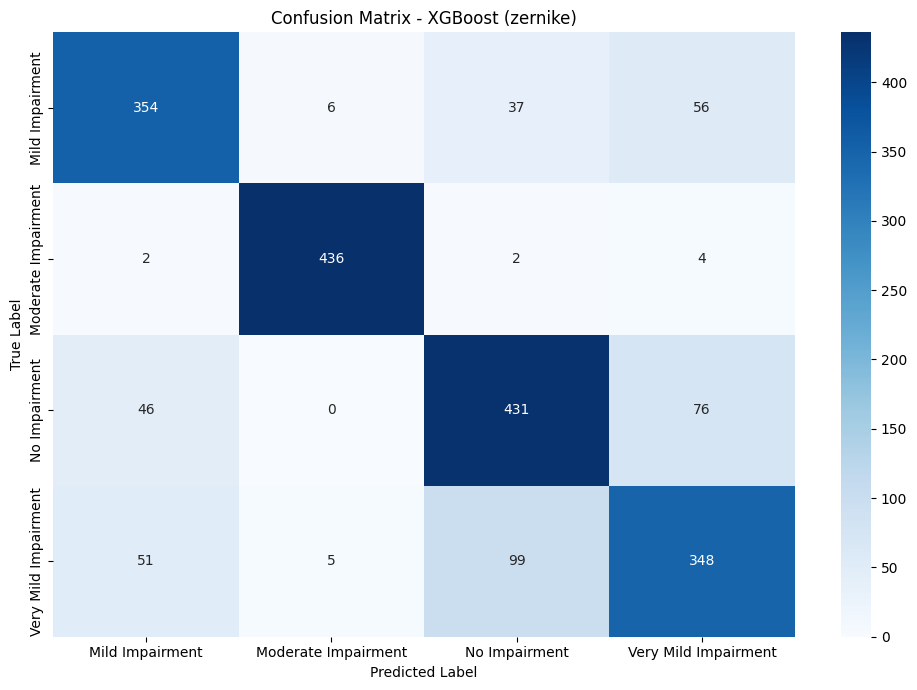

[INFO] Confusion matrix disimpan -> error_analysis\zernike_confusion_matrix.png

=== Top Misclassified Classes - zernike ===
True: Very Mild Impairment → Pred: No Impairment | Count: 99
True: No Impairment → Pred: Very Mild Impairment | Count: 76
True: Mild Impairment → Pred: Very Mild Impairment | Count: 56
True: Very Mild Impairment → Pred: Mild Impairment | Count: 51
True: No Impairment → Pred: Mild Impairment | Count: 46
True: Mild Impairment → Pred: No Impairment | Count: 37
True: Mild Impairment → Pred: Moderate Impairment | Count: 6
True: Very Mild Impairment → Pred: Moderate Impairment | Count: 5
True: Moderate Impairment → Pred: Very Mild Impairment | Count: 4
True: Moderate Impairment → Pred: Mild Impairment | Count: 2


In [93]:
# error_analysis_xgb.py
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model_dir = "trained_models"
output_dir = "error_analysis"
os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb = data["xgb"]
    le = data["label_encoder"]

    # Gunakan validation set jika ada, else test set
    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])

    y_pred = xgb.predict(X_val)

    # ====================
    # 1. Confusion Matrix
    # ====================
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - XGBoost ({feature_name})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    cm_path = os.path.join(output_dir, f"{feature_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.show()
    print(f"[INFO] Confusion matrix disimpan -> {cm_path}")

    # ====================
    # 3. Most misclassified classes
    # ====================
    misclassified = []
    for true_label_idx, true_label in enumerate(le.classes_):
        for pred_label_idx, pred_label in enumerate(le.classes_):
            if true_label_idx != pred_label_idx:
                count = cm[true_label_idx, pred_label_idx]
                if count > 0:
                    misclassified.append((true_label, pred_label, count))
    misclassified = sorted(misclassified, key=lambda x: x[2], reverse=True)

    print(f"\n=== Top Misclassified Classes - {feature_name} ===")
    for true_label, pred_label, count in misclassified[:10]:
        print(f"True: {true_label} → Pred: {pred_label} | Count: {count}")


In [100]:
# error_analysis_xgb_summary_display.py
import os
import joblib
from sklearn.metrics import confusion_matrix

model_dir = "trained_models"
output_dir = "error_analysis"
os.makedirs(output_dir, exist_ok=True)

txt_path = os.path.join(output_dir, "error_analysis_summary.txt")

total_samples_all = 0
total_errors_all = 0

lines_to_write = []
lines_to_write.append("=== ERROR ANALYSIS SUMMARY ===\n")

# Loop semua model XGBoost
for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb = data["xgb"]
    le = data["label_encoder"]

    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])
    y_pred = xgb.predict(X_val)

    lines_to_write.append(f"\nFeature: {feature_name}")
    lines_to_write.append("-"*50)
    lines_to_write.append(f"{'True Label':25} {'Total':>6} {'Misclassified':>12} {'% Error':>8} {'Example idx':>12}")

    total_per_class = {}
    for i, label in enumerate(le.classes_):
        total_per_class[i] = (y_val == i).sum()

    for true_idx, true_label in enumerate(le.classes_):
        misclassified_indices = [i for i, (t, p) in enumerate(zip(y_val, y_pred)) if t == true_idx and p != true_idx]
        count_misclassified = len(misclassified_indices)
        total_samples = total_per_class.get(true_idx, 0)
        percent_error = (count_misclassified / total_samples * 100) if total_samples > 0 else 0
        example_index = misclassified_indices[0] if misclassified_indices else None

        line = f"{true_label:25} {total_samples:6} {count_misclassified:12} {percent_error:8.2f} {str(example_index):>12}"
        lines_to_write.append(line)

        # Update total overall
        total_samples_all += total_samples
        total_errors_all += count_misclassified

# Total overall
lines_to_write.append("\n" + "="*50)
lines_to_write.append(f"TOTAL MISCLASSIFIED: {total_errors_all} / {total_samples_all} samples "
                      f"({total_errors_all/total_samples_all*100:.2f}%)")

# Simpan ke file
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines_to_write))

# Tampilkan ke layar
print("\n".join(lines_to_write))
print(f"\n[INFO] Error analysis summary disimpan -> {txt_path}")


=== ERROR ANALYSIS SUMMARY ===


Feature: fft
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment              453          115    25.39            7
Moderate Impairment          444            6     1.35          490
No Impairment                553           93    16.82           24
Very Mild Impairment         503          212    42.15            8

Feature: gist
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment              453           41     9.05           72
Moderate Impairment          444            0     0.00         None
No Impairment                553           29     5.24           20
Very Mild Impairment         503           68    13.52           17

Feature: glcm
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment     